In [ ]:
from google.colab import files
from google.colab import drive
import os
import io
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import chisquare
import numpy as np

from datetime import datetime

In [ ]:
os.getcwd()

'/content'

In [ ]:
drive.mount('/content/drive') #/MyDrive/Colab Notebooks/데이터/기상데이터

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cloud = pd.read_csv('drive/MyDrive/Colab Notebooks/데이터/기상데이터/db_cloud.csv', index_col = 0)
flight = pd.read_csv('drive/MyDrive/Colab Notebooks/데이터/기상데이터/db_flght.csv', index_col = 0)
ev = pd.read_csv('drive/MyDrive/Colab Notebooks/데이터/기상데이터/db_sfc_ev.csv', index_col = 0)

#cloud 데이터 결측치 채우기

clfm_abbr_cd : 운형약어 코드  
ca : 운량  
ch : 운고  
  
0에서 10까지 11계급으로 나눈다. 하늘에 떠 있는 모든 구름의 양을 전체 운량, 특정한 모양의 구름의 양과 특정한 높이에서만 보이는 구름의 양을 각각 구름 모양별 운량, 부분 운량이라고 한다. 운량을 나타내는 방법은 하늘에 구름이 한 점도 없을 때를 0, 구름이 하늘을 완전히 덮고 있을 때를 10으로 한다. 대체로 운량이 2 이하인 때를 맑음, 3-5일 때를 구름 조금, 6-7일 때를 구름 많음, 8 이상일 때를 흐림이라고 한다.  
운고 : 구름 밑까지의 고도

In [ ]:
cloud.isnull().sum()

cloud.tm                0
cloud.stn_id            0
cloud.clfm_abbr_cd      0
cloud.ca              692
cloud.ch              689
dtype: int64

In [ ]:
cloud[cloud['cloud.ca'].isnull()].index

Int64Index([   2393,    6176,    6751,    6759,    6760,    9154,   11307,
              22083,   30199,   30231,
            ...
            1768276, 1771879, 1809112, 1838547, 1885368, 1914015, 1925638,
            1942815, 1943255, 1945834],
           dtype='int64', name='X', length=692)

In [ ]:
list(cloud[cloud['cloud.ch'].isnull()].index)

운량과 운고의 결측치가 거의 비슷한 index, 즉 날짜에 발생하는 것을 알 수 있다.  
왜?  
특정 기상상황에 따른 오류발생 or 랜덤으로 오류발생  
특정 기상상황에 따른 오류가 발생했다면 구름의 형태에 따를 수 있다.  
랜덤으로 발생했다면 다양한 구름의 형태에서 고루 찾아볼 수 있어야 한다. 

(i) 특정 기상상황에 따른 오류인지 확인

In [ ]:
cloud.ca_notnull = cloud[cloud['cloud.ca'].notnull()]['cloud.ca']
cloud.ca_isnull = cloud[cloud['cloud.ca'].isnull()]['cloud.ca']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [ ]:
clfm_ca_notnull = cloud[cloud['cloud.ca'].notnull()]['cloud.clfm_abbr_cd']
clfm_ca_isnull = cloud[cloud['cloud.ca'].isnull()]['cloud.clfm_abbr_cd']
set(cloud['cloud.clfm_abbr_cd'])

{'Ac', 'As', 'Cb', 'Cc', 'Ci', 'Cs', 'Cu', 'Ns', 'Sc', 'St'}

In [ ]:
print(set(clfm_ca_notnull))
print(set(clfm_ca_isnull))

{'Ci', 'Cu', 'St', 'Cs', 'Ac', 'Sc', 'As', 'Cb', 'Cc', 'Ns'}
{'Ci', 'Ns', 'Cu', 'St', 'Cs', 'Sc', 'As', 'Cb', 'Cc', 'Ac'}


일단 종류는 둘다 동일한 개수의 구름의 형태가 있음.  


In [ ]:
print(clfm_ca_notnull.value_counts())
print(clfm_ca_isnull.value_counts())

cloud.ch_notnull = cloud[cloud['cloud.ch'].notnull()]['cloud.ch']
cloud.ch_isnull = cloud[cloud['cloud.ch'].isnull()]['cloud.ch']
clfm_ch_notnull = cloud[cloud['cloud.ch'].notnull()]['cloud.clfm_abbr_cd']
clfm_ch_isnull = cloud[cloud['cloud.ch'].isnull()]['cloud.clfm_abbr_cd']
print(clfm_ch_notnull.value_counts())
print(clfm_ch_isnull.value_counts())

Sc    766050
Ci    423257
As    248861
St    179257
Ns    154295
Ac    141079
Cu     26325
Cs      7269
Cb      3815
Cc      2933
Name: cloud.clfm_abbr_cd, dtype: int64
Sc    177
As    122
St     97
Ci     78
Ac     77
Ns     73
Cu     44
Cs      9
Cb      9
Cc      6
Name: cloud.clfm_abbr_cd, dtype: int64


비율이 비슷한 것 같음. 특정 기상상황에 따라 기계오류가 생겨 결측치가 생긴게 아니라 무작위로 생긴 듯 하다. (ca와 ch 어차피 결측된 시점은 거의 동일하므로 동일한 방법을 써도 무방할 듯 하다.)
가까운 날짜에 동일한 구름의 형태를 가진 행들의 평균 또는 중간값으로 imputation하는게 좋을 듯 하다. 

아 맞다, 결측이 발생한 행들의 날짜를 확인해서 연속적인 날짜들이 빠진건지, 특정 요일 또는 일수에 따라 빠진건지 아니면 진짜 날짜에도 랜덤하게 결측이 된건지 확인하기

In [ ]:
clfm_date_notnull = cloud[cloud['cloud.ch'].notnull()]['date']
clfm_date_isnull = cloud[cloud['cloud.ch'].isnull()]['date']

clfm_time_notnull = cloud[cloud['cloud.ch'].notnull()]['time']
clfm_time_isnull = cloud[cloud['cloud.ch'].isnull()]['time']

In [ ]:
print(clfm_date_notnull)
print(set(clfm_date_notnull), len(set(clfm_date_notnull)))
print(clfm_date_isnull)
print(set(clfm_date_isnull), len(set(clfm_date_isnull)))
print(clfm_time_notnull)
print(set(clfm_time_notnull), len(set(clfm_time_notnull)))
print(clfm_time_isnull)
print(set(clfm_time_isnull), len(set(clfm_time_isnull)))

In [ ]:
## cloud는 시간별로 되어 있으니까 낮/밤을 또 나누자
# --> 동일한 관측소에서, 가까운 날짜의 동일한 시간대에 동일한 구름의 형태를 가진 행들의 평균
# 07:00:00 ~ 18:00:00 > 낮
# 19:00:00 ~ 06:00:00 > 밤

날짜와 시간을 나눠서 각자 다른 열에 저장되게 하고, 사용할 수 있는 형태로 변환시켜주자

In [ ]:
cloud['date'] = cloud['cloud.tm'].map(lambda date: date[:10])
cloud['time'] = cloud['cloud.tm'].map(lambda time: time[11:-2])

cloud['date'] = pd.to_datetime(cloud['date'], format='%Y-%m-%d')
cloud['time'] = pd.to_datetime(cloud['time'], format='%H:%M:%S')

그냥 날짜에 따라 먼저 병합을 하고, 결측치도 채우자.  
--> 이러면 안되는거 아는데 시간이 없다.  
날짜/관측소별로 병합

In [ ]:
cloud.groupby(['date','cloud.stn_id']).agg(lambda x:x.value_counts().index(0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  """Entry point for launching an IPython kernel.


TypeError: ignored

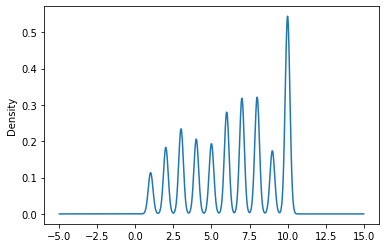

In [ ]:
cloud.ca_notnull.plot.density()

# ta.csv 전처리

In [ ]:
ta = pd.read_csv('drive/MyDrive/ta.csv', index_col = 0)


In [ ]:
#hr_rn = pd.read_csv('drive/MyDrive/hr_rn.csv', index_col = 0)
rn = pd.read_csv('drive/MyDrive/rn.csv', index_col = 0)

In [ ]:
ta.isna().sum()

a.tma           0
a.stn_id        0
a.avg_ta    29919
a.max_ta    57925
a.min_ta    57932
dtype: int64

In [ ]:
ta_max_ta_isna

18        NaN
80        NaN
122       NaN
123       NaN
178       NaN
           ..
2388396   NaN
2388475   NaN
2388552   NaN
2388670   NaN
2388718   NaN
Name: a.max_ta, Length: 57925, dtype: float64

In [ ]:
ta_avg_ta_isna

383       NaN
388       NaN
499       NaN
636       NaN
642       NaN
           ..
2388193   NaN
2388221   NaN
2388390   NaN
2388396   NaN
2388718   NaN
Name: a.avg_ta, Length: 29919, dtype: float64

In [ ]:
ta_avg_ta_isna = ta[ta['a.avg_ta'].isna()]['a.avg_ta']
ta_avg_ta_notna = ta[ta['a.avg_ta'].notna()]['a.avg_ta']

ta_max_ta_isna = ta[ta['a.max_ta'].isna()]['a.max_ta']
ta_max_ta_notna = ta[ta['a.max_ta'].notna()]['a.max_ta']

ta_min_ta_isna = ta[ta['a.min_ta'].isna()]['a.min_ta']
ta_min_ta_notna = ta[ta['a.min_ta'].notna()]['a.min_ta']

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/hist.py:147: RuntimeWarning: All-NaN slice encountered
  sample_range = np.nanmax(y) - np.nanmin(y)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/hist.py:149: RuntimeWarning: All-NaN slice encountered
  np.nanmin(y) - 0.5 * sample_range,
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/hist.py:150: RuntimeWarning: All-NaN slice encountered
  np.nanmax(y) + 0.5 * sample_range,


ValueError: ignored

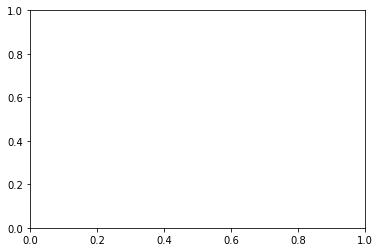

In [ ]:
ta_avg_ta_isna.plot.density(color='green')

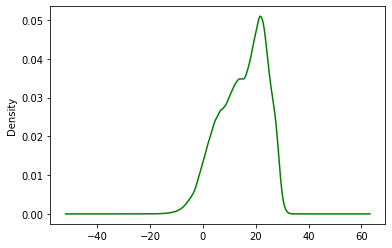

In [ ]:
ta_avg_ta_notna.plot.density(color='green')

In [ ]:
print(rn)
print(hr_rn) # hr로 시작하는거 전부 사용못함

                         a.tma  a.stn_id  a.sum_rn  a.hr1_max_rn
1        2012-02-01 00:00:00.0        15       0.0           0.0
2        2012-02-01 00:00:00.0        85       0.0           0.0
3        2012-02-01 00:00:00.0       101       0.0           0.0
4        2012-02-01 00:00:00.0       121       0.5           1.0
5        2012-02-01 00:00:00.0       129       0.0           0.0
...                        ...       ...       ...           ...
2387589  2022-10-28 00:00:00.0       959       NaN           NaN
2387590  2022-10-28 00:00:00.0       965       0.0           0.0
2387591  2022-10-28 00:00:00.0       974       0.0           0.0
2387592  2022-10-28 00:00:00.0       977       0.0           0.0
2387593  2022-10-28 00:00:00.0       990       0.0           0.0

[2387593 rows x 4 columns]
                           a.tm  a.aws_id  a.rn_day  a.rn_hr1
1         2013-02-01 00:00:00.0       169       9.0       2.0
2         2013-02-01 00:00:00.0       257       0.0       0.0
3     

In [ ]:
rn = pd.read_csv('drive/MyDrive/rn.csv', index_col = 0)
#rhm = pd.read_csv('drive/MyDrive/rhm.csv', index_col = 0)
#prsr = pd.read_csv('drive/MyDrive/prsr.csv', index_col = 0)
ta = pd.read_csv('drive/MyDrive/ta.csv', index_col = 0)
#ncdc = pd.read_csv('drive/MyDrive/db_ncdc.csv', index_col = 0)
wind = pd.read_csv('drive/MyDrive/db_aws_wind_dd.csv', index_col = 0)
cloud = pd.read_csv('drive/MyDrive/Colab Notebooks/데이터/기상데이터/db_cloud.csv', index_col = 0)
flight = pd.read_csv('drive/MyDrive/Colab Notebooks/데이터/기상데이터/db_flght.csv', index_col = 0)
#ev = pd.read_csv('drive/MyDrive/Colab Notebooks/데이터/기상데이터/db_sfc_ev.csv', index_col = 0)

In [ ]:
print(rn.columns)
#print(rhm.columns)
#print(prsr.columns)
print(ta.columns)
print(cloud.columns)
print(flight.columns)
#print(ev.columns)
print(wind.columns)

Index(['a.tma', 'a.stn_id', 'a.sum_rn', 'a.hr1_max_rn'], dtype='object')
Index(['a.tma', 'a.stn_id', 'a.avg_ta', 'a.max_ta', 'a.min_ta'], dtype='object')
Index(['a.tm', 'a.stn_id', 'a.clfm_abbr_cd', 'a.ca', 'a.ch'], dtype='object')
Index(['a.tm', 'a.stn_id', 'a.max_wd', 'a.max_ws', 'a.max_ins_wd', 'a.max_iws',
       'a.max_ta', 'a.min_ta', 'a.max_ps', 'a.min_ps', 'a.hr1_max_rn'],
      dtype='object')
Index(['a.tma', 'a.stn_id', 'a.avg_ws', 'a.mix_ws', 'a.max_ws', 'a.max_wd',
       'a.max_ws_wd', 'a.max_ins_ws', 'a.max_ins_ws_wd', 'a.mix_wd'],
      dtype='object')


In [ ]:
# cloud, flight, ev, rn, rhm, prsr, ta, wind
cloud = cloud.rename(columns={'a.tm' : 'tma', 'a.stn_id' : 'stn_id', 'a.clfm_abbr_cd' : 'cloud.clfm_abbr_cd', 'a.ca' : 'cloud.ca', 'a.ch' : 'cloud.ch'})
flight = flight.rename(columns = {'a.tm' : 'tma', 'a.stn_id' : 'stn_id', 'a.max_wd' : 'flight.max_wd', 'a.max_ws' : 'flight.max_ws', 'a.max_ins_wd' : 'flight.max_ins_wd', 'a.max_iws' : 'flight.max_ins_wd', 'a.max_ta' : 'flight.max_ta', 'a.min_ta' : 'flight.min_ta', 'a.max_ps' : 'flight.max_ps', 'a.min_ps' : 'flight.min_ps', 'a.hr1_max_rn' : 'flight.hr1_max_rn'})
#ev = ev.rename(columns = {'a.tma' : 'tma', 'a.stn_id' : 'stn_id', 'a.sum_sml_ev' : 'ev.sum_sml_ev', 'a.sum_lrg_ev' : 'ev.sum_lrg_ev'})
rn = rn.rename(columns = {'a.tma' : 'tma', 'a.stn_id' : 'stn_id', 'a.sum_rn' : 'rn.sum_rn', 'a.hr1_max_rn' : 'rn.hr1_max_rn'})
#rhm = rhm.rename(columns = {'a.tma' : 'tma', 'a.stn_id' : 'stn_id', 'a.avg_rhm' : 'rhm.avg_rhm', 'a.min_rhm' : 'rhm.min_rhm'})
#prsr = prsr.rename(columns = {'a.tma' : 'tma', 'a.stn_id' : 'stn_id', 'a.avg_pa' : 'prsr.avg_pa', 'a.max_pa' : 'prsr.max_pa', 'a.min_pa' : 'prsr.min_pa', 'a.avg_ps' : 'prsr.avg_ps','a.max_ps' : 'prsr.max_ps'})
ta = ta.rename(columns = {'a.tma' : 'tma', 'a.stn_id' : 'stn_id', 'a.avg_ta' : 'ta.avg_ta', 'a.max_ta' : 'ta.max_ta', 'a.min_ta' : 'ta.min_ta'})
wind = wind.rename(columns = {'a.tma' : 'tma', 'a.stn_id' : 'stn_id', 'a.avg_ws' : 'wind.avg_ws', 'a.mix_ws' : 'wind.mix_ws', 'a.max_ws' : 'wind.max_ws', 'a.max_wd' : 'wind.max_wd', 'a.max_ws_wd' : 'wind.max_ws_wd', 'a.max_ins_ws' : 'wind.max_ins_ws', 'a.max_ins_ws_wd' : 'wind_max_ins_ws_wd', 'a.mix_wd' : 'wind.mix_wd'})

In [ ]:
lon_lat = pd.read_csv('drive/MyDrive/mapping_0713.csv', index_col = 0)

In [ ]:
lon_lat

,name,address,lat,long,add
stn_id,,,,,
1100000000,NaN,서울특별시,37.5600,126.9800,서울
1111000000,NaN,서울특별시,37.5700,126.9800,서울
1111051500,NaN,서울특별시,37.5800,126.9700,서울
1111053000,NaN,서울특별시,37.5700,126.9700,서울
1111054000,NaN,서울특별시,37.5800,126.9800,서울
...,...,...,...,...,...
545,안산,경기도 안산시상록구 해안로870(농어촌연구원),37.2807,126.8386,경기
667,옹도,충청남도 태안군근흥면 가의도리 산510,36.6476,126.0093,충남
694,원효봉,충청남도 예산군대치리 산35-12구 KT원효봉중계소,36.7044,126.6094,충남


In [ ]:
print(cloud[cloud['address'].isnull()])
print(flight[flight['address'].isnull()])
print(ev[ev['address'].isnull()])
print(rn[rn['address'].isnull()])
print(rhm[rhm['address'].isnull()])
print(prsr[prsr['address'].isnull()])
print(ta[ta['address'].isnull()])
print(wind[wind['address'].isnull()])

Empty DataFrame
Columns: [tma, stn_id, cloud.clfm_abbr_cd, cloud.ca, cloud.ch, name, address, lat, long, add]
Index: []
Empty DataFrame
Columns: [tma, stn_id, flight.max_wd, flight.max_ws, flight.max_ins_wd, flight.max_ins_wd, flight.max_ta, flight.min_ta, flight.max_ps, flight.min_ps, flight.hr1_max_rn, name, address, lat, long, add]
Index: []
Empty DataFrame
Columns: [tma, stn_id, ev.sum_sml_ev, ev.sum_lrg_ev, name, address, lat, long, add]
Index: []
Empty DataFrame
Columns: [tma, stn_id, rn.sum_rn, rn.hr1_max_rn, name, address, lat, long, add]
Index: []
Empty DataFrame
Columns: [tma, stn_id, rhm.avg_rhm, rhm.min_rhm, name, address, lat, long, add]
Index: []
Empty DataFrame
Columns: [tma, stn_id, prsr.avg_pa, prsr.max_pa, prsr.min_pa, prsr.avg_ps, prsr.max_ps, a.min_ps, name, address, lat, long, add]
Index: []
Empty DataFrame
Columns: [tma, stn_id, ta.avg_ta, ta.max_ta, ta.min_ta, name, address, lat, long, add]
Index: []
Empty DataFrame
Columns: [tma, stn_id, wind.avg_ws, wind.mix_ws

In [ ]:
cloud['date'] = cloud['tma'].map(lambda date_cloud: date_cloud[:10])
cloud['time'] = cloud['tma'].map(lambda time_cloud: time_cloud[11:-2])
cloud['date'] = pd.to_datetime(cloud['date'], format='%Y-%m-%d')
cloud['time'] = pd.to_datetime(cloud['time'], format='%H:%M:%S')

flight['date'] = flight['tma'].map(lambda date_flight: date_flight[:10])
flight['time'] = flight['tma'].map(lambda time_flight: time_flight[11:-2])
flight['date'] = pd.to_datetime(flight['date'], format='%Y-%m-%d')
flight['time'] = pd.to_datetime(flight['time'], format='%H:%M:%S')

rn['date'] = rn['tma'].map(lambda date_rn: date_rn[:10])
rn['time'] = rn['tma'].map(lambda time_rn: time_rn[11:-2])
rn['date'] = pd.to_datetime(rn['date'], format='%Y-%m-%d')
rn['time'] = pd.to_datetime(rn['time'], format='%H:%M:%S')

#rhm['date'] = rhm['tma'].map(lambda date_rhm: date_rhm[:10])
#rhm['time'] = rhm['tma'].map(lambda time_rhm: time_rhm[11:-2])
#rhm['date'] = pd.to_datetime(rhm['date'], format='%Y-%m-%d')
#rhm['time'] = pd.to_datetime(rhm['time'], format='%H:%M:%S')

#prsr['date'] = prsr['tma'].map(lambda date_prsr: date_prsr[:10])
#prsr['time'] = prsr['tma'].map(lambda time_prsr: time_prsr[11:-2])
#prsr['date'] = pd.to_datetime(prsr['date'], format='%Y-%m-%d')
#prsr['time'] = pd.to_datetime(prsr['time'], format='%H:%M:%S')

ta['date'] = ta['tma'].map(lambda date_ta: date_ta[:10])
ta['time'] = ta['tma'].map(lambda time_ta: time_ta[11:-2])
ta['date'] = pd.to_datetime(ta['date'], format='%Y-%m-%d')
ta['time'] = pd.to_datetime(ta['time'], format='%H:%M:%S')

wind['date'] = wind['tma'].map(lambda date_wind: date_wind[:10])
wind['time'] = wind['tma'].map(lambda time_wind: time_wind[11:-2])
wind['date'] = pd.to_datetime(wind['date'], format='%Y-%m-%d')
wind['time'] = pd.to_datetime(wind['time'], format='%H:%M:%S')

In [ ]:
flight

,tma,stn_id,flight.max_wd,flight.max_ws,flight.max_ins_wd,flight.max_ins_wd,flight.max_ta,flight.min_ta,flight.max_ps,flight.min_ps,flight.hr1_max_rn,date,time
X,,,,,,,,,,,,,
1,2012-02-01 00:00:00.0,92,32.0,20.0,32.0,28.0,-25.0,-118.0,10251.0,10158.0,NaN,2012-02-01,1900-01-01
2,2012-02-01 00:00:00.0,110,33.0,13.0,32.0,17.0,-89.0,-195.0,10306.0,10219.0,NaN,2012-02-01,1900-01-01
3,2012-02-01 00:00:00.0,113,34.0,18.0,36.0,24.0,-67.0,-129.0,10307.0,10219.0,NaN,2012-02-01,1900-01-01
4,2012-02-01 00:00:00.0,128,26.0,14.0,31.0,17.0,-32.0,-171.0,10305.0,10213.0,NaN,2012-02-01,1900-01-01
5,2012-02-01 00:00:00.0,139,27.0,18.0,27.0,26.0,20.0,-88.0,10248.0,10162.0,NaN,2012-02-01,1900-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40288,2022-10-29 00:00:00.0,158,3.0,5.0,36.0,11.0,232.0,40.0,10278.0,10241.0,NaN,2022-10-29,1900-01-01
40289,2022-10-29 00:00:00.0,161,7.0,9.0,7.0,12.0,212.0,67.0,10282.0,10246.0,NaN,2022-10-29,1900-01-01
40290,2022-10-29 00:00:00.0,163,35.0,10.0,35.0,13.0,215.0,82.0,10274.0,10246.0,NaN,2022-10-29,1900-01-01


In [ ]:
## cloud, flight, rn, rhm, prsr, ta, wind
del cloud['name']
del cloud['address']

del flight['name']
del flight['address']

del rn['name']
del rn['address']

#del rhm['name']
#del rhm['address']

#del prsr['name']
#del prsr['address']

del ta['name']
del ta['address']

del wind['name']
del wind['address']


## 먼저 각 데이터를 그럼 일별 데이터로 맞춰주자

### cloud 데이터를 제외하면 모두 연속형 변수라 쉬움  
cloud 데이터 제외하고 나머지를 먼저 하자

prsr이랑 rhm은 통째로 빈 날짜가 많아서 폐기  
남은 데이터 : cloud, flight, rn, ta, wind


In [ ]:
# cloud, flight, rn, ta, wind
cloud = pd.merge(cloud, lon_lat, on = ['stn_id'])
flight = pd.merge(flight, lon_lat, on = ['stn_id'])
rn = pd.merge(rn, lon_lat, on = ['stn_id'])
ta = pd.merge(ta, lon_lat, on = ['stn_id'])
wind = pd.merge(wind, lon_lat, on = ['stn_id'])

In [ ]:
# cloud, flight, rn, rhm, prsr, ta, wind
flight = flight.groupby(['date', 'stn_id']).mean()
rn = rn.groupby(['date', 'stn_id']).mean()
#rhm = rhm.groupby(['date', 'stn_id']).mean()
#prsr = prsr.groupby(['date', 'stn_id']).mean()
ta = ta.groupby(['date', 'stn_id']).mean()
wind = wind.groupby(['date', 'stn_id']).mean()

In [ ]:
print(cloud.columns)
print(flight.columns)
print(rn.columns)
print(ta.columns)
print(wind.columns)

Index(['tma', 'stn_id', 'cloud.clfm_abbr_cd', 'cloud.ca', 'cloud.ch', 'date',
       'time'],
      dtype='object')
Index(['tma', 'stn_id', 'flight.max_wd', 'flight.max_ws', 'flight.max_ins_wd',
       'flight.max_ins_wd', 'flight.max_ta', 'flight.min_ta', 'flight.max_ps',
       'flight.min_ps', 'flight.hr1_max_rn', 'date', 'time'],
      dtype='object')
Index(['tma', 'stn_id', 'rn.sum_rn', 'rn.hr1_max_rn', 'date', 'time'], dtype='object')
Index(['tma', 'stn_id', 'ta.avg_ta', 'ta.max_ta', 'ta.min_ta', 'date', 'time'], dtype='object')
Index(['tma', 'stn_id', 'wind.avg_ws', 'wind.mix_ws', 'wind.max_ws',
       'wind.max_wd', 'wind.max_ws_wd', 'wind.max_ins_ws',
       'wind_max_ins_ws_wd', 'wind.mix_wd', 'date', 'time'],
      dtype='object')


In [ ]:
del cloud['tma']
#del cloud['name']
del cloud['time']
#del cloud['address']

del flight['tma']
#del flight['name']
del flight['time']
#del flight['address']

del rn['tma']
#del rn['name']
del rn['time']
#del rn['address']

del ta['tma']
#del ta['name']
del ta['time']
#del ta['address']

del wind['tma']
#del wind['name']
del wind['time']
#del wind['address']

In [ ]:
flight

,stn_id,flight.max_wd,flight.max_ws,flight.max_ins_wd,flight.max_ins_wd,flight.max_ta,flight.min_ta,flight.max_ps,flight.min_ps,flight.hr1_max_rn,date
X,,,,,,,,,,,
1,92,32.0,20.0,32.0,28.0,-25.0,-118.0,10251.0,10158.0,NaN,2012-02-01
2,110,33.0,13.0,32.0,17.0,-89.0,-195.0,10306.0,10219.0,NaN,2012-02-01
3,113,34.0,18.0,36.0,24.0,-67.0,-129.0,10307.0,10219.0,NaN,2012-02-01
4,128,26.0,14.0,31.0,17.0,-32.0,-171.0,10305.0,10213.0,NaN,2012-02-01
5,139,27.0,18.0,27.0,26.0,20.0,-88.0,10248.0,10162.0,NaN,2012-02-01
...,...,...,...,...,...,...,...,...,...,...,...
40288,158,3.0,5.0,36.0,11.0,232.0,40.0,10278.0,10241.0,NaN,2022-10-29
40289,161,7.0,9.0,7.0,12.0,212.0,67.0,10282.0,10246.0,NaN,2022-10-29
40290,163,35.0,10.0,35.0,13.0,215.0,82.0,10274.0,10246.0,NaN,2022-10-29


In [ ]:
flight_ds = flight.groupby(['date', 'stn_id'], as_index=False).mean()
rn_ds = rn.groupby(['date', 'stn_id'], as_index=False).mean()
ta_ds = ta.groupby(['date', 'stn_id'], as_index=False).mean()
wind_ds = wind.groupby(['date', 'stn_id'], as_index=False).mean()

In [ ]:
#cloud = pd.merge(cloud, lon_lat, on = ['stn_id'])
flight_ds = pd.merge(flight_ds, lon_lat, on = ['stn_id'])
rn_ds = pd.merge(rn_ds, lon_lat, on = ['stn_id'])
ta_ds = pd.merge(ta_ds, lon_lat, on = ['stn_id'])
wind_ds = pd.merge(wind_ds, lon_lat, on = ['stn_id'])

In [ ]:
flight_ds_m = flight_ds.groupby(['date', 'add'], as_index=False).mean()
rn_ds_m = rn_ds.groupby(['date', 'add'], as_index=False).mean()
ta_ds_m = ta_ds.groupby(['date', 'add'], as_index=False).mean()
wind_ds_m = wind_ds.groupby(['date', 'add'], as_index=False).mean()

In [ ]:
print(flight_ds_m.isna().sum())
print(rn_ds_m.isna().sum())
print(ta_ds_m.isna().sum())
print(wind_ds_m.isna().sum())

date                     0
add                      0
stn_id                   0
flight.max_wd            4
flight.max_ws            4
flight.max_ins_wd        4
flight.max_ins_wd        4
flight.max_ta            4
flight.min_ta            4
flight.max_ps            4
flight.min_ps            4
flight.hr1_max_rn    13668
lat                      0
long                     0
dtype: int64
date             0
add              0
stn_id           0
rn.sum_rn        0
rn.hr1_max_rn    0
lat              0
long             0
dtype: int64
date         0
add          0
stn_id       0
ta.avg_ta    0
ta.max_ta    0
ta.min_ta    0
lat          0
long         0
dtype: int64
date                  0
add                   0
stn_id                0
wind.avg_ws           0
wind.mix_ws           0
wind.max_ws           1
wind.max_wd           0
wind.max_ws_wd        1
wind.max_ins_ws       0
wind_max_ins_ws_wd    0
wind.mix_wd           1
lat                   0
long                  0
dtype: int64


In [ ]:
ta_ds_m.to_csv('drive/MyDrive/Colab Notebooks/데이터/기상데이터/ta.csv')

In [ ]:
rn_ds_m.to_csv('drive/MyDrive/Colab Notebooks/데이터/기상데이터/rn.csv')

In [ ]:
len(flight_ds_m)

18813

flight.hr1_max_rn변수는 18813행 중 13668행이 결측이라 변수제거.  
flight_ds_m의 나머지 변수들의 결측치 개수가 같아서 아마 결측된 행이 동일할 것으로 예상. 확인해보자.  
  

flight.max_wd, flight.max_ws, flight.max_ins_wd, flight.max_ins_wd, flight.max_ta, flight.min_ta, flight.max_ps, flight.min_ps

In [ ]:
del flight_ds_m['flight.hr1_max_rn']
del flight_ds_m['flight.max_ins_wd'] # 중복된 열이 있어서 제거

In [ ]:
print(flight_ds_m[flight_ds_m['flight.max_wd'].isna()])
print(flight_ds_m[flight_ds_m['flight.max_ws'].isna()])
print(flight_ds_m[flight_ds_m['flight.max_ta'].isna()])
print(flight_ds_m[flight_ds_m['flight.min_ta'].isna()])
print(flight_ds_m[flight_ds_m['flight.max_ps'].isna()])
print(flight_ds_m[flight_ds_m['flight.min_ps'].isna()])

            date add  stn_id  flight.max_wd  flight.max_ws  flight.max_ta  \
7924  2016-05-19  서울   110.0            NaN            NaN            NaN   
15907 2020-10-27  강원    92.0            NaN            NaN            NaN   
15956 2020-11-06  제주   182.0            NaN            NaN            NaN   
16913 2021-07-21  인천   113.0            NaN            NaN            NaN   

       flight.min_ta  flight.max_ps  flight.min_ps      lat      long  
7924             NaN            NaN            NaN  37.5569  126.7975  
15907            NaN            NaN            NaN  38.0667  128.6667  
15956            NaN            NaN            NaN  33.5167  126.5000  
16913            NaN            NaN            NaN  37.4625  126.4392  
            date add  stn_id  flight.max_wd  flight.max_ws  flight.max_ta  \
7924  2016-05-19  서울   110.0            NaN            NaN            NaN   
15907 2020-10-27  강원    92.0            NaN            NaN            NaN   
15956 2020-11-06  제주   

In [ ]:
print(wind_ds_m[wind_ds_m['wind.max_ws'].isna()])
print(wind_ds_m[wind_ds_m['wind.max_ws_wd'].isna()])
print(wind_ds_m[wind_ds_m['wind.mix_wd'].isna()])

           date add  stn_id  wind.avg_ws  wind.mix_ws  wind.max_ws  \
9270 2013-09-30  대구   665.5          1.6        1.075          NaN   

      wind.max_wd  wind.max_ws_wd  wind.max_ins_ws  wind_max_ins_ws_wd  \
9270      163.125             NaN             5.95              213.75   

      wind.mix_wd        lat        long  
9270          NaN  35.828705  128.559044  
           date add  stn_id  wind.avg_ws  wind.mix_ws  wind.max_ws  \
9270 2013-09-30  대구   665.5          1.6        1.075          NaN   

      wind.max_wd  wind.max_ws_wd  wind.max_ins_ws  wind_max_ins_ws_wd  \
9270      163.125             NaN             5.95              213.75   

      wind.mix_wd        lat        long  
9270          NaN  35.828705  128.559044  
           date add  stn_id  wind.avg_ws  wind.mix_ws  wind.max_ws  \
9270 2013-09-30  대구   665.5          1.6        1.075          NaN   

      wind.max_wd  wind.max_ws_wd  wind.max_ins_ws  wind_max_ins_ws_wd  \
9270      163.125             NaN

모든 변수에 대해서 결측행이 동일한 것을 확인